In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


In [3]:
# -------------------------------------------------------------------
# Establish correct ROOT (project folder)
# -------------------------------------------------------------------
CWD = Path.cwd()

if (CWD / "src").exists():           
    ROOT = CWD
elif (CWD.parent / "src").exists():  
    ROOT = CWD.parent
elif (CWD.parent.parent / "src").exists():  
    ROOT = CWD.parent.parent
else:
    raise RuntimeError("Could not locate project root.")

print("PROJECT ROOT:", ROOT)

# -------------------------------------------------------------------
# Add src to python path
# -------------------------------------------------------------------
if str(ROOT / "src") not in sys.path:
    sys.path.insert(0, str(ROOT / "src"))

# Now import module inside src/preprocessing
from preprocessing.gse48113 import (
    parse_meta,
    read_agilent_fe,
    extract_expression
)

# -------------------------------------------------------------------
# Data directories
# -------------------------------------------------------------------
RAW_DIR = ROOT / "notebooks" / "data" / "raw"
PROCESSED_DIR = ROOT / "notebooks" / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("RAW DIR:", RAW_DIR)
print("FILES FOUND:", len(list(RAW_DIR.glob('*.txt.gz'))))
print("Proc DIR:", PROCESSED_DIR)



PROJECT ROOT: d:\OneDrive\Documents\My Docs\CMU\Fall '25\Model & Sims\Project\ODE-to-Circadian-Clocks
RAW DIR: d:\OneDrive\Documents\My Docs\CMU\Fall '25\Model & Sims\Project\ODE-to-Circadian-Clocks\notebooks\data\raw
FILES FOUND: 287
Proc DIR: d:\OneDrive\Documents\My Docs\CMU\Fall '25\Model & Sims\Project\ODE-to-Circadian-Clocks\notebooks\data\processed


In [4]:
files = sorted(RAW_DIR.glob("*.txt.gz"))

if not files:
    raise RuntimeError("No .txt.gz FE files detected in data/. Place raw files there.")

meta = pd.DataFrame([parse_meta(f) for f in files])
meta = meta.sort_values(["subject", "t_idx"]).reset_index(drop=True)
meta.to_csv(PROCESSED_DIR / "sample_metadata.csv", index=False)

meta.head()


,gsm,subject,condition,t_idx,file
0,GSM1168586,BB0012,R,1,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...
1,GSM1168587,BB0012,R,2,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...
2,GSM1168588,BB0012,R,3,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...
3,GSM1168589,BB0012,R,4,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...
4,GSM1168590,BB0012,R,5,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...


In [5]:
# SKIP WHEN RERUNNING

dfs = []
for _, row in meta.iterrows():
    fe = read_agilent_fe(Path(row["file"]))
    ex = extract_expression(fe)

    ex["gsm"] = row["gsm"]
    ex["subject"] = row["subject"]
    ex["t_idx"] = row["t_idx"]
    dfs.append(ex)

full_df = pd.concat(dfs, ignore_index=True)
full_df["intensity"] = pd.to_numeric(full_df["intensity"], errors="coerce")


In [6]:
expr = full_df.groupby(["gene", "gsm"])["intensity"].mean().reset_index()
expr_mat = expr.pivot(index="gene", columns="gsm", values="intensity")

expr_mat.to_csv(PROCESSED_DIR / "expression_matrix.csv")
expr_mat.shape

expr_log = np.log2(expr_mat + 1)

mu = expr_log.mean(axis=1)
sd = expr_log.std(axis=1) + 1e-8

expr_norm = (expr_log.sub(mu, axis=0)).div(sd, axis=0)
expr_norm.to_csv(PROCESSED_DIR / "expression_matrix_normalized.csv")
expr_norm.shape

(29872, 287)

In [7]:
# -------------------------------------------------------
# Remove genes or samples that contain NaN after norm
# -------------------------------------------------------

# Drop genes with any NaN
expr_norm = expr_norm.dropna(axis=0, how='any')

# Drop samples with NaN (rare but safe)
expr_norm = expr_norm.dropna(axis=1, how='any')

print("After NaN removal:", expr_norm.shape)


After NaN removal: (29872, 287)


In [8]:
# Keep only samples whose GSM survived NaN filtering
valid_gsm = expr_norm.columns
meta = meta[meta.gsm.isin(valid_gsm)].copy()

# Sort again
meta = meta.sort_values(["subject", "t_idx"])

# Reindex expression using the filtered metadata
expr_norm = expr_norm.loc[:, meta.gsm.values]


In [9]:
X = expr_norm.T.values   # samples × genes
pca = PCA().fit(X)
cum_var = np.cumsum(pca.explained_variance_ratio_)
n_pcs = int(np.searchsorted(cum_var, 0.95) + 1)
print("PCs covering 99% variance:", n_pcs)

X_pca = pca.transform(X)[:, :n_pcs]

pc_cols = [f"PC{i+1}" for i in range(n_pcs)]
pca_df = meta.copy()

for i, col in enumerate(pc_cols):
    pca_df[col] = X_pca[:, i]

pca_df.to_csv(PROCESSED_DIR / "pca_timeseries_tidy.csv", index=False)
pca_df.head()


PCs covering 99% variance: 73


,gsm,subject,condition,t_idx,file,PC1,PC2,PC3,PC4,PC5,...,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73
0,GSM1168586,BB0012,R,1,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...,64.168170,-27.418664,43.646636,-0.101706,-23.352152,...,0.698589,-1.229142,-2.240858,-2.190744,0.404511,4.482297,2.193591,-0.644868,5.706536,0.363680
1,GSM1168587,BB0012,R,2,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...,-33.991239,45.176533,28.941916,-13.572325,-64.780063,...,3.076734,-0.727980,-4.696755,0.131975,-0.156676,-2.505054,1.093372,-2.545352,9.402123,0.410718
2,GSM1168588,BB0012,R,3,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...,25.048800,-2.073032,61.041862,2.931691,-15.358187,...,-4.969462,2.240797,-2.571849,1.009576,-3.356887,0.531541,5.134797,1.798963,7.240246,-0.835983
3,GSM1168589,BB0012,R,4,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...,-23.497055,0.863986,44.373005,2.623108,-0.796365,...,0.089464,6.413426,0.133634,-0.385346,-3.249325,-0.728925,1.326212,2.140040,6.079606,-1.099492
4,GSM1168590,BB0012,R,5,d:\OneDrive\Documents\My Docs\CMU\Fall '25\Mod...,41.795072,-12.719064,57.735303,-19.669015,2.667161,...,0.355259,-3.660681,-6.854918,2.488281,-1.370487,-1.837389,2.660678,0.734274,-8.092224,-0.510687


In [10]:
subjects = sorted(meta.subject.unique())

train_sub, rest = train_test_split(subjects, test_size=0.4, random_state=1)
val_sub, test_sub = train_test_split(rest, test_size=0.5, random_state=1)

splits = pd.DataFrame({
    "subject": train_sub + val_sub + test_sub,
    "split":  ["train"]*len(train_sub) +
              ["val"]*len(val_sub) +
              ["test"]*len(test_sub)
})

splits.to_csv(PROCESSED_DIR / "subject_splits.csv", index=False)
splits


,subject,split
0,BB0239,train
1,BB0080,train
2,BB0098,train
3,BB0028,train
4,BB0148,train
5,BB0012,train
6,BB0289,train
7,BB0272,train
8,BB0102,train
9,BB0100,train


In [11]:
train_df = pca_df[pca_df.subject.isin(train_sub)]
val_df = pca_df[pca_df.subject.isin(val_sub)]
test_df = pca_df[pca_df.subject.isin(test_sub)]

train_df.to_csv(PROCESSED_DIR / "pca_train.csv", index=False)
val_df.to_csv(PROCESSED_DIR / "pca_val.csv", index=False)
test_df.to_csv(PROCESSED_DIR / "pca_test.csv", index=False)


C:\Users\Sanchitha\AppData\Local\Temp\ipykernel_36032\3722393554.py:8: RuntimeWarning: invalid value encountered in log1p
  sns.histplot(np.log1p(expr_norm.values.flatten()), bins=100, kde=True)


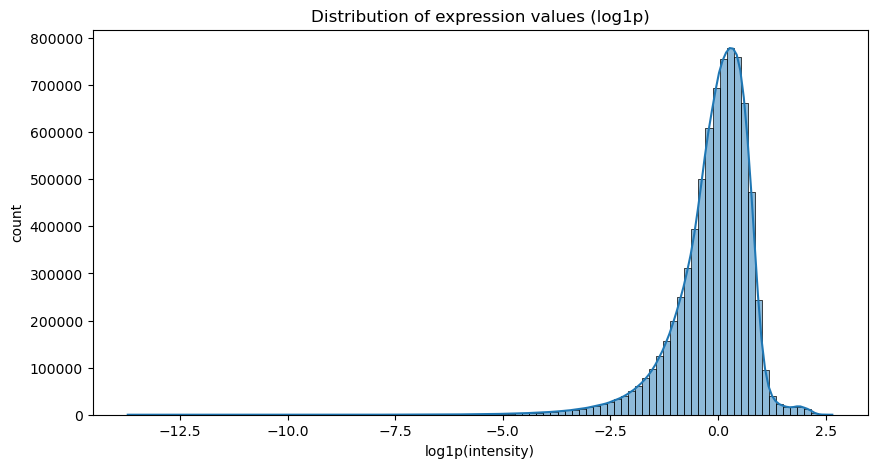

In [12]:
# Sanity checks

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,5))
sns.histplot(np.log1p(expr_norm.values.flatten()), bins=100, kde=True)
plt.title("Distribution of expression values (log1p)")
plt.xlabel("log1p(intensity)")
plt.ylabel("count")
plt.show()


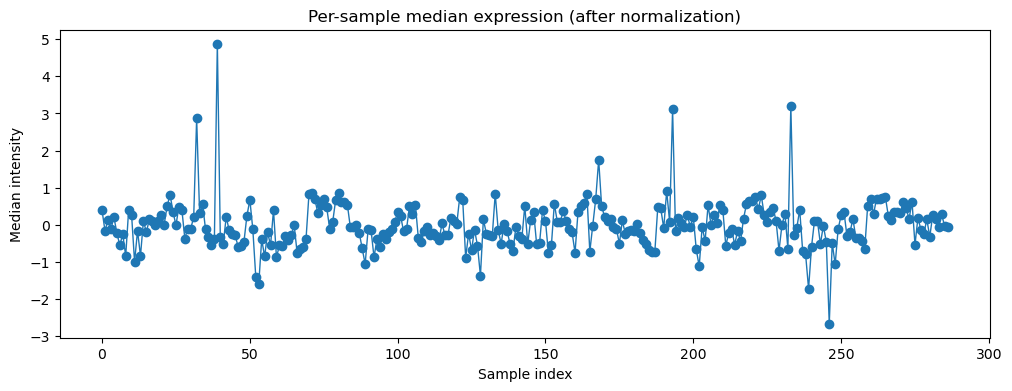

In [13]:

sample_medians = expr_norm.median(axis=0)

plt.figure(figsize=(12,4))
plt.plot(sample_medians.values, marker='o', lw=1)
plt.title("Per-sample median expression (after normalization)")
plt.xlabel("Sample index")
plt.ylabel("Median intensity")
plt.show()


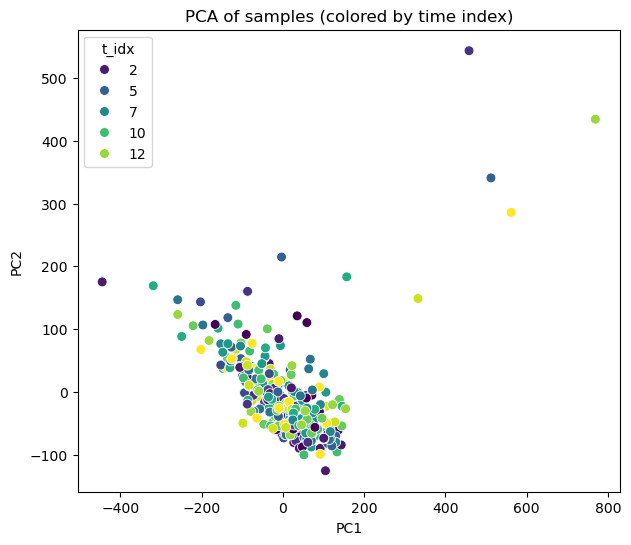

In [14]:
# Reindex meta so GSM IDs are the index
meta_idx = meta.set_index("gsm")

# PCA
X = expr_norm.T.values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Extract t_idx in correct sample order
t_idx_values = meta_idx.loc[expr_norm.columns, "t_idx"]

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=t_idx_values,
    palette="viridis", s=50
)
plt.title("PCA of samples (colored by time index)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="t_idx")
plt.show()


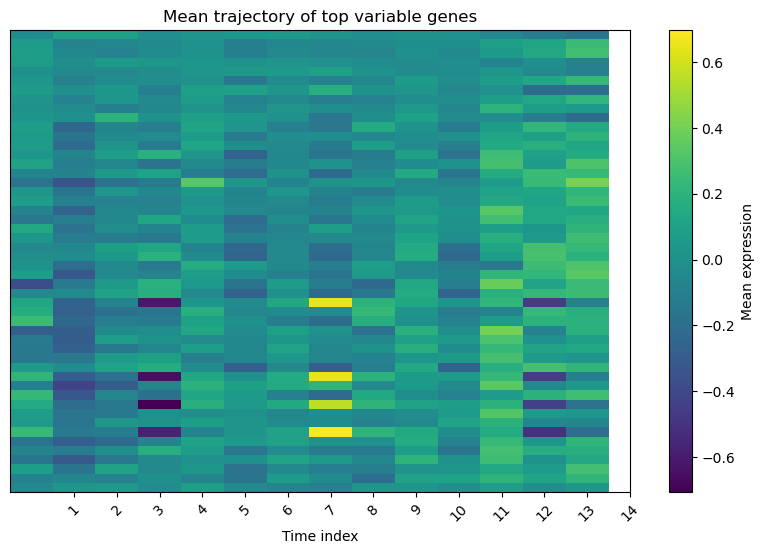

In [15]:
# Pick top 50 most variable genes
gene_var = expr_norm.var(axis=1)
top_genes = gene_var.nlargest(50).index

expr_top = expr_norm.loc[top_genes]

# Compute mean trajectory across subjects for each time point
t_vals = sorted(meta['t_idx'].unique())
mean_per_time = {t: expr_top[meta[meta.t_idx == t].gsm].mean(axis=1) for t in t_vals}

mean_mat = np.column_stack([mean_per_time[t] for t in t_vals])

plt.figure(figsize=(10,6))
plt.imshow(mean_mat, aspect='auto', cmap='viridis')
plt.colorbar(label="Mean expression")
plt.yticks([])
plt.xticks(t_vals, rotation=45)
plt.title("Mean trajectory of top variable genes")
plt.xlabel("Time index")
plt.show()


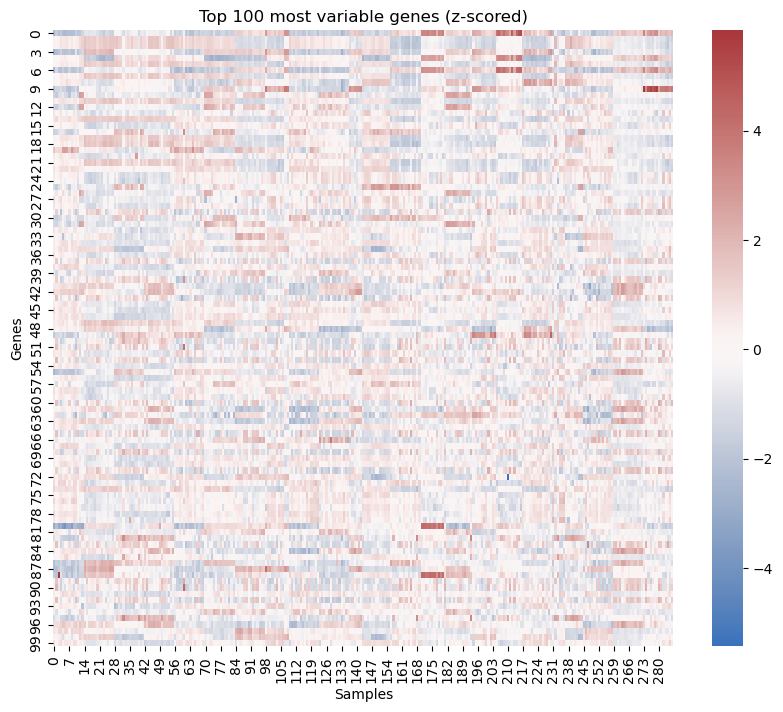

In [16]:
from sklearn.preprocessing import StandardScaler

top100 = gene_var.nlargest(100).index
X_top = expr_norm.loc[top100]

# Standardize per-gene (rows)
X_scaled = StandardScaler().fit_transform(X_top)

plt.figure(figsize=(10,8))
sns.heatmap(X_scaled, cmap="vlag", center=0)
plt.title("Top 100 most variable genes (z-scored)")
plt.xlabel("Samples")
plt.ylabel("Genes")
plt.show()


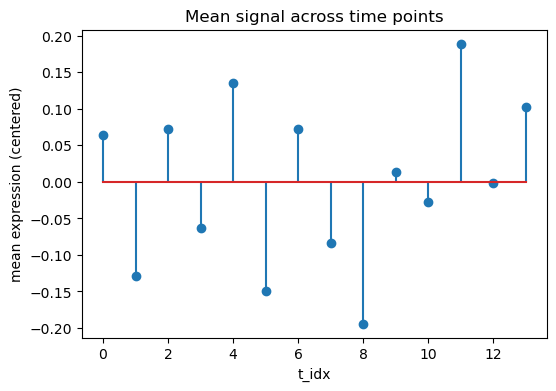

In [61]:
# Mean expression across genes per timepoint
mean_tp = {
    t: expr_norm[meta[meta.t_idx == t].gsm].mean(axis=1).mean()
    for t in t_vals
}
series = np.array([mean_tp[t] for t in t_vals])

plt.figure(figsize=(6,4))
plt.stem(series - series.mean())
plt.title("Mean signal across time points")
plt.xlabel("t_idx")
plt.ylabel("mean expression (centered)")
plt.show()
